# The charging station

`pyspect` can set up problems independently from implementations...
At this stage, we only need to import pyspect and select a pyspect language...

In [2]:
import sys
import os

# Get the path to the parent folder of 'examples' (i.e., the 'pyscept' folder)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add the 'src' directory to Python's search path
src_path = os.path.join(parent_dir, "src")
sys.path.append(src_path)



from math import pi

from pyspect import *
from pyspect.langs.ltl import *

TLT.select(ContinuousLTL)

## Environment

Let us first setup the 4-way intersection environment...

In [3]:
## CONSTANTS ##

# Define origin and size of area, makes it easier to scale up/down later on 
X0, XN = -2, 4
Y0, YN = -2, 4

STATE_INIT = [X0+7.5*XN/8, Y0+2.5*YN/8, pi, 0]

Speedlimit bound

In [4]:
## TRAFFIC RULES ##

speedlimit = BoundedSet(v=(0.3, 0.6))

Setting up bounds

In [12]:
## ROADS ##

intersection = And(
    BoundedSet(x=(X0, X0 + 0.25*XN), y=(Y0 + 0.125*YN, Y0 + 0.375*YN)),
    speedlimit
)

road_n = BoundedSet(x=(X0 + 0.125*XN, X0 + 0.25*XN), h=(+pi/2 - pi/5, +pi/2 + pi/5))
road_n = Or(And(road_n, speedlimit), intersection)

road_s = BoundedSet(x=(X0, X0 + 0.125*XN), h=(-pi/2 - pi/5, -pi/2 + pi/5))
road_s = Or(road_s, intersection)

exit_n = And(BoundedSet(x=(X0 + 0.125*XN, X0 + 0.25*XN), y=(Y0 + 0.875*YN, Y0 + YN)), road_n)
exit_s = And(BoundedSet(x=(X0, X0 + 0.125*XN), y=(Y0, Y0 + 0.125 * YN)), road_s)

## PARKING LOT ##

parking_lot = Or(
    BoundedSet(x=(X0 + 0.25*XN, X0 + 0.375*XN), y=(Y0 + 1*YN/8, Y0 + 3*YN/8)),  # Entry/Exit
    BoundedSet(x=(X0 + 0.375*XN, X0 + XN), y=(Y0, Y0 + 0.5*YN))                     # Main box
)

parking_space_1 = BoundedSet(x=(X0 + 0.875*XN, X0 + XN), y=(Y0, Y0 + 0.125*YN))
parking_space_2 = BoundedSet(x=(X0 + 0.875*XN, X0 + XN), y=(Y0 + 0.125*YN, Y0 + 0.25*YN))
parking_space_3 = BoundedSet(x=(X0 + 0.875*XN, X0 + XN), y=(Y0 + 0.25*YN, Y0 + 0.375*YN))


## Testing scenario

test_space = BoundedSet(x=(X0, X0 + XN), y=(Y0, Y0 + YN))
test_mid = BoundedSet(x=(X0+3*XN/8, X0+5*XN/8), y=(Y0+3*YN/8, Y0+5*YN/8))

In [10]:
def FollowTo(constraint, goal_or_constraint, *more):
    if more: # 2nd arg is constraint
        return FollowTo(And(constraint, goal_or_constraint), *more)
    else: # 2nd arg is exit
        return Until(constraint, goal_or_constraint)

Three vehicles in the scenario must follow these rules...

In [13]:
vehicle_1 = FollowTo(Or(road_s, road_n, parking_lot), exit_n)

# vehicle_2 = FollowTo(road_n, Not(vehicle_1), exit_n)

# vehicle_3 = FollowTo(road_e, Not(vehicle_1), Not(vehicle_2), exit_e)

vehicle_test = FollowTo(test_space, test_mid)

Implementation using `hj_reachability`.

In [14]:
import numpy as np
import hj_reachability as hj

class HJImpl(ContinuousLTL.Impl):

    solver_settings = hj.SolverSettings.with_accuracy("low")

    def __init__(self, dynamics, grid, time_horizon):
        self.grid = grid
        self.ndim = grid.ndim
        self.dynamics = dynamics
        self.timeline = self.new_timeline(time_horizon)
           
    def new_timeline(self, target_time, start_time=0, time_step=0.2):
        assert time_step > 0
        is_forward = target_time >= start_time
        target_time += 1e-5 if is_forward else -1e-5
        time_step *= 1 if is_forward else -1
        return np.arange(start_time, target_time, time_step)

    def set_axes_names(self, *args):
        assert len(args) == self.ndim
        self._axes_names = tuple(args)

    def axis(self, name: str) -> int:
        assert name in self._axes_names, f'Axis ({name=}) does not exist.'
        return self._axes_names.index(name)

    def axis_name(self, i: int) -> str:
        assert i < len(self._axes_names), f'Axis ({i=}) does not exist.'
        return self._axes_names[i]

    def axis_is_periodic(self, i: int) -> bool:
        assert i < len(self._axes_names), f'Axis ({i=}) does not exist.'
        return bool(self.grid._is_periodic_dim[i])

    def plane_cut(self, normal, offset, axes=None):
        data = np.zeros(self.grid.shape)
        axes = axes or list(range(self.grid.ndim))
        x = lambda i: self.grid.states[..., i]
        for i, k, m in zip(axes, normal, offset):
            data -= k*x(i) - k*m
        return data

    def empty(self):
        return np.ones(self.grid.shape)*np.inf
    
    def complement(self, vf):
        return np.asarray(-vf)
    
    def intersect(self, vf1, vf2):
        return np.maximum(vf1, vf2)

    def union(self, vf1, vf2):
        return np.minimum(vf1, vf2)
    
    def reach(self, target, constraints=None):
        self.dynamics.with_mode('reach')
        if not self.is_invariant(target):
            target = np.flip(target, axis=0)
        if not self.is_invariant(constraints):
            constraints = np.flip(constraints, axis=0)
        vf = hj.solve(self.solver_settings,
                      self.dynamics,
                      self.grid,
                      -self.timeline,
                      target,
                      constraints)
        return np.flip(np.asarray(vf), axis=0)
    
    def avoid(self, target, constraints=None):
        self.dynamics.with_mode('avoid')
        if not self.is_invariant(target):
            target = np.flip(target, axis=0)
        if not self.is_invariant(constraints):
            constraints = np.flip(constraints, axis=0)
        vf = hj.solve(self.solver_settings,
                      self.dynamics,
                      self.grid,
                      -self.timeline,
                      target,
                      constraints)
        return np.flip(np.asarray(vf), axis=0)

    def project_onto(self, vf, *idxs, keepdims=False, union=True):
        idxs = [len(vf.shape) + i if i < 0 else i for i in idxs]
        dims = [i for i in range(len(vf.shape)) if i not in idxs]
        if union:
            return vf.min(axis=tuple(dims), keepdims=keepdims)
        else:
            return vf.max(axis=tuple(dims), keepdims=keepdims)

    def is_invariant(self, vf):
        return (True if vf is None else
                len(vf.shape) != len(self.timeline.shape + self.grid.shape))

    def make_tube(self, vf):
        return (vf if not self.is_invariant(vf) else
                np.concatenate([vf[np.newaxis, ...]] * len(self.timeline)))

In [21]:
from hj_reachability.systems import Bicycle5D
from pyspect.plotting.levelsets import *


min_bounds_input = np.array([-5*pi/4, -0.4])
max_bounds_input = np.array([ 5*pi/4,  0.4])
reach_dynamics = Bicycle5D(min_steer=min_bounds_input[0],
                           max_steer=max_bounds_input[0],
                           min_accel=min_bounds_input[1],
                           max_accel=max_bounds_input[1])

min_bounds_state = np.array([   X0,    Y0, -pi, -pi/6, +0.3])
max_bounds_state = np.array([XN+X0, YN+Y0, +pi, +pi/6, +0.8])
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(min_bounds_state, max_bounds_state),
                                                               (31, 31, 25, 7, 7),
                                                               periodic_dims=2)

impl = HJImpl(reach_dynamics, grid, 15)
impl.set_axes_names('x', 'y', 'h', 'd', 'v')

out1 = TLT.construct(vehicle_1).realize(impl)
# out2 = TLT.construct(vehicle_2).realize(impl)
# out3 = TLT.construct(vehicle_3).realize(impl)

100%|##########| 15.0000/15.0 [09:33<00:00, 38.21s/sim_s]


In [62]:
plot3D_levelset(impl.project_onto(out1, 0, 1, 2),
                min_bounds=[0, *min_bounds_state[:2]],
                max_bounds=[15, *max_bounds_state[:2]])

# plot3D_levelset(impl.project_onto(out1, 0, 3, 4),
#                 min_bounds=[0, *min_bounds[2:4]],
#                 max_bounds=[10, *max_bounds[2:4]])

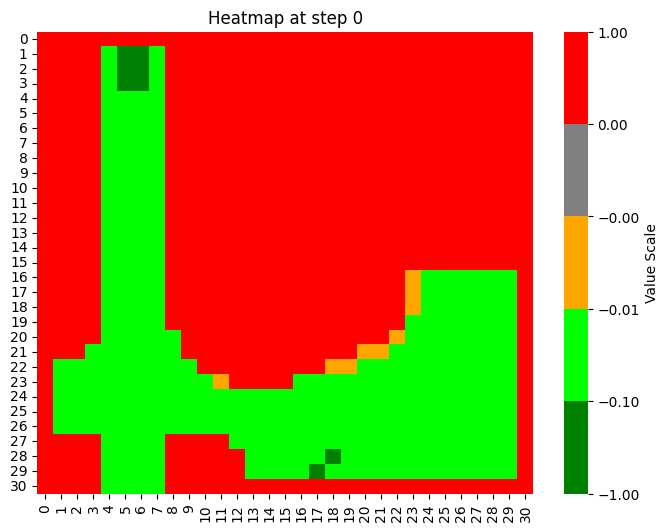

In [24]:
### HEAT-MAP ###

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import seaborn as sns

# Example: Create a matrix of arrays

t = 0
out1_heat_pos = np.rot90(out1[t].min(axis=(2,3,4)))

# Create a custom colormap where 0 is gray and other values use coolwarm
colors = ["green","lime", "orange", "gray", "red"]  # Include gray for 0
cmap = ListedColormap(colors)

# Define boundaries to control the color mapping
bounds = [-1,-0.1,-0.01, -1e-5, 0, 1]  # Ensure 0 is within its own boundary
norm = BoundaryNorm(bounds, cmap.N)

# Plot the heatmap
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(out1_heat_pos, cmap=cmap, norm=norm, cbar_kws={'ticks': bounds, 'label': 'Value Scale'})

plt.title("Heatmap at step "+str(t))
plt.show()

(31, 31) (31, 31)
-0.13333336


C:\Users\lukas\AppData\Local\Temp\ipykernel_13552\1078934930.py:42: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\lukas\AppData\Local\Temp\ipykernel_13552\1078934930.py:43: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



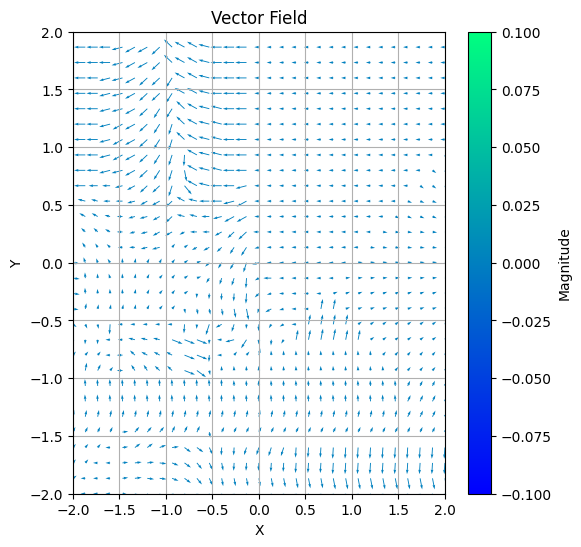

In [246]:
### VECTOR FIELD (whole area) ###

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import seaborn as sns


# Create a custom colormap where 0 is gray and other values use coolwarm
colors = ["lime", "gray", "red"]  # Include gray for 0
cmap = ListedColormap(colors)

# Define boundaries to control the color mapping
bounds = [-1,-1e-5, 0, 1]  # Ensure 0 is within its own boundary
norm = BoundaryNorm(bounds, cmap.N)


# Define grid
x, y = np.meshgrid(np.linspace(X0, X0+XN, 31), np.linspace(Y0, Y0+YN, 31))
print(np.shape(x),np.shape(y))

u = np.zeros(np.shape(x))
v = np.zeros(np.shape(y))

value_array = np.zeros(np.shape(x))

t = 0


for row in range(len(out1[t,0,:,0,0])):
    for col in range(len(out1[t,:,0,0,0])):
        
        min_value = np.min(out1[0,col,row,:,:])
        min_index = np.where(out1[0,col,row,:,:] == min_value)
        if np.shape(min_index) != (2, 1):
            ind_theta = min_index[0][0]
            ind_v = min_index[1][0]
            
        else:
            ind_theta, ind_v = min_index

        u[col,row] = (0.3 + 0.5*ind_v/7) * np.cos((-1 + 2*ind_theta/25) * np.pi)
        v[col,row] = (0.3 + 0.5*ind_v/7) * np.sin((-1 + 2*ind_theta/25) * np.pi)

        # value_array[col,row] = -1 * len(min_index[0])
        # print(len(min_index[0]))
        value_array[col,row] = min(value_array[col,row],1e-5)
        # print(u[col,row],v[col,row])

print(np.min(out1[t]))
# print(out1[t,:,:,:,:])
# Plot vector field
plt.figure(figsize=(6,6))
plt.quiver(x, y, u, v, value_array, cmap="winter")

# Show plot
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Vector Field")
plt.colorbar(label="Magnitude")
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.grid()
plt.show()


28 2


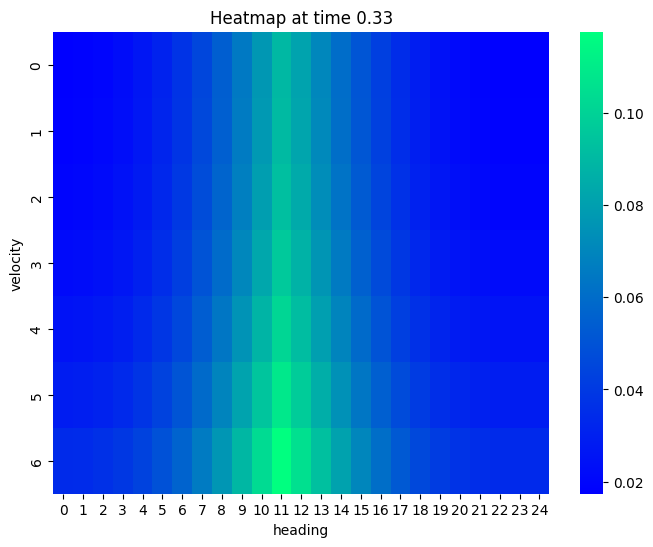

In [248]:
### HEAT MAP (from specific point) ###

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import seaborn as sns

# Example: Create a matrix of arrays

t = 25
# x_init = STATE_INIT[0]
# y_init = STATE_INIT[1]
x_init = X0 + 7.5*XN/8
y_init = Y0 + 0.5*YN/8
dx = XN / 30
dy = YN / 30
ind_x_init = round((x_init - X0)/dx)
ind_y_init = round((y_init - Y0)/dy)

print(ind_x_init,ind_y_init)

out1_heat_pos = np.rot90(out1[t,ind_x_init,ind_y_init,:,:,:])
# print(out1_heat_pos)

# Plot the heatmap
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(out1_heat_pos, cmap="winter")

plt.title("Heatmap at time "+str(round(t/len(out1), 2)))
plt.xlabel("heading")
plt.ylabel("velocity")
# plt.scatter([0],[0],s=100,color="black")
plt.show()

Optimization of unconstrained problem with casadi (doesn't handle MINLP)

In [162]:
### MPC WITHOUT WARM-STARTING, GOAL IS A POINT ###

import casadi as ca

# Parameters
L = 0.8  # Wheelbase of the vehicle
tau = 0.2  # Time constant
dt = 0.2  # Time step (s)
N = 10  # Prediction horizon

# Define the bicycle model dynamics
def bicycle_dynamics(state, control):
    """
    Bicycle model dynamics with CasADi-compatible indexing.\n
    state = [x, y, theta, omega, v]\n
    control = [delta, a]
    """
    x = state[0]        # x-coordinate
    y = state[1]        # y-coordinate
    theta = state[2]    # Yaw/Heading
    omega = state[3]    # Change rate of yaw
    v = state[4]        # Velocity
    
    delta = control[0]  # Steering angle
    a = control[1]      # Acceleration

    # Compute the state derivatives
    dx = v * ca.cos(theta)
    dy = v * ca.sin(theta)
    dtheta = omega
    domega = v/L*np.tan(delta)-omega/tau
    dv = a
    
    return ca.vertcat(dx, dy, dtheta, domega, dv)  # Return as a vertical concatenation


# MPC setup
opti = ca.Opti()  # Create optimization problem

# State and control variables
X = opti.variable(5, N + 1)  # State trajectory [x, y, theta, omega, v]
U = opti.variable(2, N)  # Control inputs [delta, a]
x0 = opti.parameter(5)  # Initial state [x, y, theta, omega, v]
x_goal = opti.parameter(5)  # [x, y, theta, omega, v]


# Cost function
cost = 0
Q = np.diag([1,0,0,0,0])
# Q_T = np.diag([100,0,1,1,1])
Q_T = Q
R = np.diag([0,1])

for t in range(N):
    # Tracking cost: minimize distance to goal
    cost += ca.mtimes([(X[:, t] - x_goal).T, Q, X[:, t] - x_goal])
    
    # Control effort cost: minimize acceleration and steering
    cost += ca.mtimes([U[:, t].T, R, U[:, t]])

# Terminal cost (final state close to goal)
cost += ca.mtimes([(X[:, t] - x_goal).T, Q_T, X[:, t] - x_goal])

### Constraints

# Bounds on state
bounds_X = np.array([min_bounds_state,
                    max_bounds_state])
bounds_U = np.array([min_bounds_input,
                     max_bounds_input])

for i in range(4):
    opti.subject_to(X[i, :] >= bounds_X[0,i])
    opti.subject_to(X[i, :] <= bounds_X[1,i])
for i in range(2):
    opti.subject_to(U[i, :] >= bounds_U[0,i])
    opti.subject_to(U[i, :] <= bounds_U[1,i])


# Dynamics
opti.subject_to(X[:, 0] == x0)  # Initial state constraint
for t in range(N):
    # System dynamics constraint
    opti.subject_to(X[:, t + 1] == X[:, t] + dt * bicycle_dynamics(X[:, t], U[:, t]))

# Obstacles
obst_list = []
obst_rad = 1/12 * XN

for y in range(3,8):
    obst_list.append([X0+2.5*XN/8, Y0+(y+0.5)*YN/8])

for x in range(3,8):
    obst_list.append([X0+(x+0.5)*XN/8, Y0+4.5*YN/8])

obst_list.append([X0+2.5*XN/8, Y0+0.5*YN/8])

for ob in obst_list:
    opti.subject_to((X[0,:] - ob[0])**2 + (X[1,:] - ob[1])**2 >= obst_rad**2)

# Solver settings
opti.minimize(cost)
opti.solver('ipopt', {
    "ipopt.max_iter": 10000,  # Set max iterations
    "print_time": 0,  # Suppress IPOPT solver output
    "ipopt.print_level": 0
})

# Simulation setup
x_init = np.array([X0+7.5*XN/8, Y0+2.5*YN/8, pi, 0, 0])      # Start state [x, y, theta, omega, v]
goal = np.array([X0+1.5*XN/8, Y0+7.5*YN/8, pi/2, 0, 0.8])       # Goal state [x, y, theta, omega, v]

x_warm_start = np.linspace(x_init[0], goal[0], N+1)
y_warm_start = np.linspace(0, 0, N+1)
theta_warm_start = np.linspace(pi, pi, N+1)
v_warm_start = np.linspace(0, 0.1, N+1)



opti.set_value(x0, x_init)
opti.set_value(x_goal, goal)
opti.set_initial(X[0,:], x_warm_start)
opti.set_initial(X[1,:], y_warm_start)
opti.set_initial(X[2,:], theta_warm_start)
opti.set_initial(X[4,:], v_warm_start)
sol = opti.solve()

trajectory = sol.value(X)
    
# Solve the optimization problem
sol = opti.solve()

# Convert trajectory to a numpy array for plotting
trajectory = np.array(trajectory)

# print(trajectory)

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:165:
.../casadi/core/optistack_internal.cpp:1030: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Infeasible_Problem_Detected'

C:\Users\lukas\AppData\Local\Temp\ipykernel_19760\4223567421.py:19: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



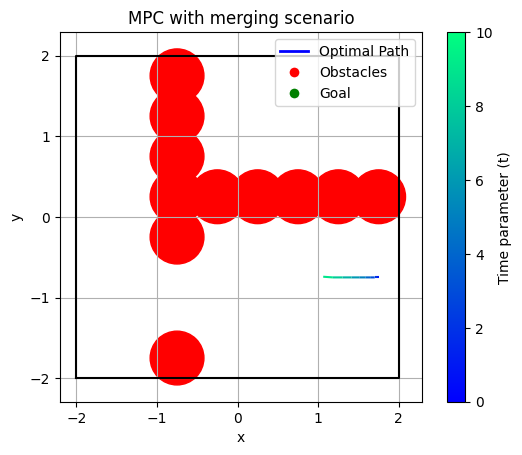

In [161]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
import matplotlib.patches as patches

# Define the line points
t = np.linspace(0, N, N+1)  # Time or parameter for the line
x = trajectory[0, :]  # X-coordinates
y = trajectory[1, :]  # Y-coordinates

# Create segments for gradient effect
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Define colormap (from blue to green)
cmap = cm.get_cmap("winter")  # 'winter' is a built-in blue-to-green colormap
norm = plt.Normalize(t.min(), t.max())  # Normalize colors based on t

# Create a LineCollection with colors
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(t)  # Use t to define color transition

# Plot
fig, ax = plt.subplots()
ax.add_collection(lc)
ax.set_aspect('equal')  # Keep axis scale proportional

# Add colorbar
cb = plt.colorbar(lc, ax=ax)
cb.set_label("Time parameter (t)")

# Plot goal
# ax.scatter(goal[0], goal[1], color='green', label='Goal')
# ax.add_patch(patches.Circle((goal[0], goal[1]), obst_rad/2, color='green'))

# Plot obstacles (large dots on the plot)
for obst in obst_list:
    ax.add_patch(patches.Circle((obst[0], obst[1]), obst_rad, color='red'))

# Add box
ax.plot([X0, X0, X0+XN, X0+XN, X0], [Y0, Y0+YN, Y0+YN, Y0, Y0], color='black')

# Fix labels
plt.xlabel('x')
plt.ylabel('y')
plt.title('MPC with merging scenario')

# Create custom legend entries
line_legend = Line2D([0], [0], color='blue', lw=2, label='Optimal Path')
obstacle_legend = Line2D([0], [0], marker='o', color='w', markersize=8, 
                         markerfacecolor='red', label='Obstacles')
goal_legend = Line2D([0], [0], marker='o', color='w', markersize=8, 
                      markerfacecolor='green', label='Goal')

ax.legend(handles=[line_legend, obstacle_legend, goal_legend], loc='upper right')

ax.grid(True)
plt.show()


Optimization with cplex

In [129]:
# # first import the Model class from docplex.mp
# from docplex.mp.model import Model
# import math
# import numpy as np

# L = 1

# # create one model instance, with a name
# m = Model(name='Merging_scenario')

# # by default, all variables in Docplex have a lower bound of 0 and infinite upper bound
# x = m.continuous_var(name='x')
# y = m.continuous_var(name='y')
# v = m.continuous_var(name='v')
# theta = m.continuous_var(name='theta')

# cos_theta = 1-theta**2/2
# sin_theta = theta
# tan_delta = theta

# a = m.continuous_var(name='a')
# delta = m.continuous_var(name='delta')

# state = [x,y,v,theta]
# input = [a,delta]

# xdot = [v*cos_theta,v*sin_theta,a,v/L*tan_delta]


# # constraint #3: assembly time limit
# ct_assembly = m.add_constraint(x**2 <= 400)
# ct_assembly = m.add_constraint(y**2 <= x)

# # constraint #4: paiting time limit
# # ct_painting = m.add_constraint( 0.5 * desk + 0.4 * cell <= 490)

# m.maximize(state[0] + state[1])

# m.print_information()

# s = m.solve()
# m.print_solution()